In [1]:
import numpy as np
import json
import pandas as pd
from k_means_constrained import KMeansConstrained
import seaborn as sns
import pulp
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from itertools import chain
from datetime import datetime
import math

In [2]:
# load the JSON file
with open("C:/Users/ADMIN/Downloads/model_build_inputs/model_build_inputs/route_data.json") as f:
    route = json.load(f)

# count the number of keys
num_routes = len(route.keys())

print(f"The JSON file has {num_routes} routes.")

The JSON file has 6112 routes.


In [3]:
routedf=pd.DataFrame(route)
routedf=routedf.T
routedf.shape

(6112, 6)

In [4]:
routedf

,station_code,date_YYYY_MM_DD,departure_time_utc,executor_capacity_cm3,route_score,stops
RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77,DLA3,2018-07-27,16:02:10,3313071.0,High,"{'AD': {'lat': 34.099611, 'lng': -118.283062, ..."
RouteID_0016bc70-cb8d-48b0-aa55-8ee50bdcdb59,DSE4,2018-07-28,15:44:41,4247527.0,High,"{'AC': {'lat': 47.689446, 'lng': -122.296071, ..."
RouteID_001948e9-4675-486d-9ec5-912fd8e0770f,DSE5,2018-08-18,15:32:04,4247527.0,High,"{'AA': {'lat': 47.268001, 'lng': -122.5079, 't..."
RouteID_001b4ee3-c4f2-467f-932b-c85524d1021f,DLA9,2018-08-15,15:09:38,3313071.0,High,"{'AB': {'lat': 33.823076, 'lng': -118.058727, ..."
RouteID_0021a2aa-780f-460d-b09a-f301709e2523,DLA7,2018-08-05,14:23:26,3313071.0,High,"{'AA': {'lat': 33.84364, 'lng': -117.773651, '..."
...,...,...,...,...,...,...
RouteID_ffd16e94-e3db-435f-a128-1ddcb2a34e54,DAU1,2018-07-24,13:47:59,4247527.0,Medium,"{'AA': {'lat': 30.292536, 'lng': -97.745191, '..."
RouteID_ffe98097-93df-44b0-9c45-4fedbafae3f3,DCH4,2018-08-10,14:07:25,3313071.0,Medium,"{'AC': {'lat': 42.187711, 'lng': -88.262079, '..."
RouteID_ffebb6fc-ce81-46db-b2a1-2750c0333185,DCH3,2018-07-25,14:10:26,3313071.0,High,"{'AA': {'lat': 41.858479, 'lng': -88.322974, '..."
RouteID_fff2548c-1069-4340-8e50-08420efe435d,DLA8,2018-07-29,15:13:39,4247527.0,High,"{'AQ': {'lat': 34.065987, 'lng': -118.363671, ..."


In [5]:
index_high=routedf[routedf["route_score"]=="Medium"].index
routedf.index.get_loc(index_high[0])

6

In [6]:
def get_route_score(score,routedf):
    total_numbers=[]
    indicies=routedf[routedf["route_score"]==score].index
    for index in indicies:
        total_numbers.append(routedf.index.get_loc(index))
    return total_numbers

In [7]:
get_route_score("High",routedf)

[0,
 1,
 2,
 3,
 4,
 5,
 9,
 12,
 16,
 19,
 20,
 21,
 23,
 24,
 25,
 27,
 28,
 29,
 30,
 32,
 35,
 38,
 40,
 42,
 43,
 44,
 46,
 47,
 49,
 50,
 55,
 57,
 58,
 62,
 63,
 64,
 67,
 68,
 71,
 77,
 78,
 80,
 82,
 83,
 85,
 86,
 88,
 94,
 95,
 100,
 102,
 103,
 112,
 113,
 115,
 120,
 121,
 122,
 127,
 128,
 129,
 133,
 135,
 137,
 138,
 139,
 143,
 145,
 146,
 147,
 149,
 150,
 151,
 152,
 153,
 155,
 156,
 160,
 162,
 165,
 167,
 171,
 174,
 176,
 178,
 180,
 184,
 185,
 186,
 188,
 189,
 191,
 193,
 197,
 199,
 201,
 206,
 207,
 212,
 214,
 215,
 216,
 217,
 219,
 221,
 222,
 226,
 227,
 229,
 235,
 236,
 238,
 239,
 241,
 243,
 244,
 247,
 249,
 250,
 251,
 252,
 254,
 255,
 256,
 268,
 269,
 274,
 276,
 277,
 280,
 281,
 284,
 286,
 290,
 291,
 293,
 294,
 295,
 300,
 301,
 303,
 305,
 307,
 308,
 311,
 313,
 318,
 319,
 323,
 326,
 327,
 333,
 336,
 338,
 340,
 342,
 343,
 344,
 346,
 349,
 351,
 352,
 353,
 354,
 357,
 358,
 359,
 360,
 366,
 369,
 373,
 375,
 380,
 381,
 383,
 384,


In [8]:
# load the JSON file
with open("C:/Users/ADMIN/Downloads/model_build_inputs/model_build_inputs/travel_times.json") as f:
    travel= json.load(f)

# count the number of keys
num_travels = len(travel.keys())

print(f"The JSON file has {num_travels} .")


The JSON file has 6112 .


In [9]:
traveldf=pd.DataFrame(travel)
traveldf=traveldf.T
traveldf.shape

(6112, 675)

In [10]:
def choose_route(number):
    route_distances=pd.DataFrame(traveldf.iloc[number].to_dict()).dropna(axis=1)
    route_stops_data=pd.DataFrame.from_dict(routedf[ 'stops'][number], orient='columns').T
    return route_distances, route_stops_data

number=20
route_distances, route_stops_data=choose_route(number=number)

In [11]:
    
X=np.array(route_distances).transpose()
n_samples=len(X)
n_clusters=int(len(X)/10)
#n_clusters=2
clf = KMeansConstrained(
    n_clusters=n_clusters,
    size_min=int(n_samples/n_clusters)-2,
    size_max=int(n_samples/n_clusters)+1,
    random_state=0
     )
clf.fit_predict(X)

route_stops_data["Cluster"]=clf.labels_
route_stops_data["lat"]=route_stops_data["lat"].astype('float')
route_stops_data["lng"]=route_stops_data["lng"].astype('float')
departure_point=route_stops_data[route_stops_data["type"]=="Station"].index[0]
route_stops_data.at[departure_point,'Cluster']=-1
route_stops_data["Cluster"]=route_stops_data["Cluster"].astype('category')


def get_cluster_points(num_cluster):
    return route_stops_data[route_stops_data["Cluster"]==num_cluster]

def get_distances_cluster(num_cluster):
    cluster_points_data=get_cluster_points(num_cluster)
    cols=cluster_points_data.index.to_list()
    route_cluster_distances=route_distances[cols]
    route_cluster_distances=route_cluster_distances.loc[cluster_points_data.index]
    distances_list_cluster=[]
    for i in range (route_cluster_distances.shape[0]):
        for j in range (route_cluster_distances.shape[1]):
            if i!=j:
                row=route_cluster_distances.index[i]
                column=route_cluster_distances.columns[j]
                value=route_cluster_distances.loc[row][column]
                distances_list_cluster.append((row,column,value))
    return distances_list_cluster

<AxesSubplot:xlabel='lat', ylabel='lng'>

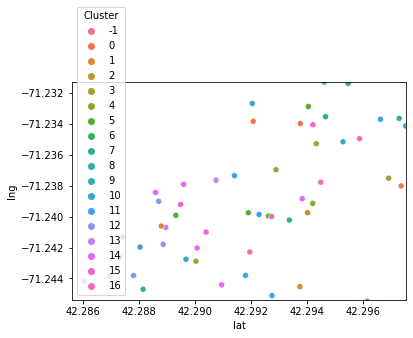

In [12]:
fig, ax = plt.subplots()
ax.set_xlim(route_stops_data.describe().loc["25%"]["lat"],route_stops_data.describe().loc["75%"]["lat"])
ax.set_ylim(route_stops_data.describe().loc["25%"]["lng"],route_stops_data.describe().loc["75%"]["lng"])
sns.scatterplot(data=route_stops_data,x=route_stops_data["lat"], y=route_stops_data["lng"], hue=route_stops_data["Cluster"])

In [13]:
# load the JSON file
with open("C:/Users/ADMIN/Downloads/model_build_inputs/model_build_inputs/package_data.json") as f:
    package = json.load(f)

# count the number of keys
num_packages = len(route.keys())

print(f"The JSON file has {num_packages} packages.")

The JSON file has 6112 packages.


In [14]:
packages_df=pd.DataFrame(package)
route=packages_df.columns[number]
packages_route=packages_df[[route]]
packages_route=packages_route.loc[route_stops_data.index]
packages_route.head()

,RouteID_00ace8b4-30c6-4a20-a723-74ece636a0da
AA,{'PackageID_662da45e-c499-42ef-8048-a537d9be0d...
AE,{'PackageID_c845c9ca-a023-46ce-87ad-93fc67ab1a...
AF,{'PackageID_04a3ebbd-71ec-45d4-b610-52751fe79b...
AH,{'PackageID_d0ac9323-90e7-4705-9e86-9b86f27464...
AN,{'PackageID_d3a08438-443d-4123-b4b0-fdc58590d6...


In [15]:
origin_time=datetime.strptime(routedf.iloc[number]["date_YYYY_MM_DD"]+" "+"00:00:00",'%Y-%m-%d %H:%M:%S')
def isNaN(string):
    return string != string

def remove_nan(L):
    if L==[]:
        L=[np.nan]
    new_list=[]
    for e in L:
        if isNaN(e)==False:
            new_list.append(e)
    if new_list==[]:
        new_list=[L[0]]
    return new_list

def get_starts_ends():
    start=[]
    end=[]
    starts=[]
    ends=[]
    for i in range (len(packages_route)):
        stop=packages_route.index[i]
        if pd.isna(packages_route.loc[stop][0]):
            continue
        keys=packages_route.loc[stop][0].keys()
        keys=list(keys)
        for k in keys:
            start.append(packages_route.loc[stop][0].get(k).get('time_window').get('start_time_utc'))
            end.append(packages_route.loc[stop][0].get(k).get('time_window').get('end_time_utc'))
        start_cleaned=remove_nan(start)
        end_cleaned=remove_nan(end)
        start_package=min(start_cleaned)
        end_package=max(end_cleaned)
        starts.append((stop,start_package))
        ends.append((stop,end_package))
        start=[]
        end=[]
    return (dict(starts),dict(ends))

starts,ends=get_starts_ends()


def get_starts_ends_without_nans(starts,ends):

    non_null=[]
    
    for element in starts:
        if isNaN(starts[element])==False:
            non_null.append(starts[element])
    min_time=min(non_null)
    non_null=[]
    for element in ends:
        if isNaN(ends[element])==False:
            non_null.append(ends[element])
    max_time=max(non_null)   
    for element in starts:
        if isNaN(starts[element]):
            starts[element]=min_time
    for element in ends:
        if isNaN(ends[element]):
            ends[element]=max_time
    return (starts,ends)

starts, ends=get_starts_ends_without_nans(starts,ends)
def get_ab_per_cluster(stop_stations,starts,ends):
    starts_per_cluster=[]
    ends_per_cluster=[]
    for stop in stop_stations:
        date_difference=datetime.strptime(starts[stop], '%Y-%m-%d %H:%M:%S')-origin_time
        days=date_difference.days
        seconds=date_difference.seconds
        total_time=days*24*3600+seconds
        starts_per_cluster.append(total_time)
        date_difference=datetime.strptime(ends[stop], '%Y-%m-%d %H:%M:%S')-origin_time
        days=date_difference.days
        seconds=date_difference.seconds
        total_time=days*24*3600+seconds
        ends_per_cluster.append(total_time)
    return (starts_per_cluster,ends_per_cluster)


In [16]:
def apply_algorithm_per_cluster(num_cluster,flag=0):
    path= r'C:\Program Files\IBM\ILOG\CPLEX_Studio2211\cplex\bin\x64_win64\cplex.exe'
    G=nx.DiGraph()
    cluster=get_cluster_points(num_cluster=num_cluster)
    stop_stations=list(cluster.index)
    nodes=stop_stations
    edges=get_distances_cluster(num_cluster)
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(edges)
    P=[]
    L=[]
    for i in stop_stations:
        for j in stop_stations:
            if i!=j:
                L.append(G[i][j]["weight"])
            else:
                L.append(0)
        P.append(L)
        L=[]
    a,b=get_ab_per_cluster(stop_stations,starts,ends)
    M=(max(b)+max(list(chain.from_iterable(P))))*10
    problem=pulp.LpProblem("Amazon_projet",pulp.LpMinimize)
    X=[[pulp.LpVariable(f"X{i}_{j}", cat=pulp.LpBinary) for j in nodes] for i in nodes]
    t=[pulp.LpVariable(name=f"t{i}",cat=pulp.LpContinuous,lowBound=a[i],upBound=b[i]) for i in range(len(nodes))]
    problem += pulp.lpSum([X[i][j]*P[i][j] for i in range(len(nodes))  for j in range(len(nodes))])
    for i in range(len(nodes)):
        if i != len(nodes)-1:
            problem += pulp.lpSum([X[i][j] for j in range(0, len(nodes))])==1
        if i!=len(nodes)-1 and i!=0:
            problem += pulp.lpSum([X[i][j] for j in range(0, len(nodes))]) ==pulp.lpSum([X[j][i] for j in range(0, len(nodes))])
        if i==0:
            problem += pulp.lpSum([X[i][j] for j in range(0, len(nodes))])-pulp.lpSum([X[j][i] for j in range(0, len(nodes))])==1
        if i==len(nodes)-1:
            problem += pulp.lpSum([X[i][j] for j in range(0, len(nodes))]) - pulp.lpSum([X[j][i] for j in range(0, len(nodes))]) == -1
        problem+=X[i][i]==0
    for j in range(len(nodes)):
        if j!=0:
            problem += pulp.lpSum([X[i][j] for i in range(0, len(nodes))]) == 1
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            t[i]+P[i][j]-t[j]<=M*(1-X[i][j])
    for k in range(len(nodes)):
        for S in range(2, len(nodes)):
            for subset in itertools.combinations([i for i in range(len(nodes)) if i != k], S):
                problem += pulp.lpSum([X[i][j] for i in subset for j in subset if i != j]) <= len(subset) - 1
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if pulp.value(X[i][j])==1:
                edges_selected.append((nodes[i],nodes[j],P[i][j]))
    solver = pulp.CPLEX_CMD(path=path)
    problem.solve(solver)
    if flag==1:
        print("La valeur de la fonction objective: ",pulp.value(problem.objective))
        for i in range(len(nodes)):
             for j in range(len(nodes)):
                print(f"la valeur de X{nodes[i]}_{nodes[j]} est: {pulp.value(X[i][j])}")
    edges_selected=[]
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if pulp.value(X[i][j])==1:
                edges_selected.append((nodes[i],nodes[j],P[i][j]))
    return edges_selected

In [17]:
def draw_graph(num_cluster):
    sol=nx.DiGraph()
    cluster=get_cluster_points(num_cluster=num_cluster)
    nodes=list(cluster.index)
    edges=apply_algorithm_per_cluster(num_cluster)
    sol.add_nodes_from(nodes)
    sol.add_weighted_edges_from(edges)
    weight = nx.get_edge_attributes(sol, 'weight')
    pos= nx.circular_layout(sol)
    nx.draw_networkx(sol,pos=pos, with_labels=True,node_size= 1000, node_color='r', edge_color='g', arrowsize=35, font_size=18)
    nx.draw_networkx_edge_labels(sol,pos=pos,edge_labels=weight , font_size =15)
    plt.title("Cluster 0")
    plt.savefig(f"{num_cluster}.png")
    plt.show()

In [18]:
def solution_draw_per_cluster(n_clusters):
    for i in range(n_clusters):
        print(f"La solution pour le cluster {i} :")
        draw_graph(i)

La solution pour le cluster 0 :


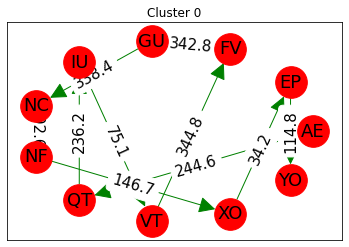

La solution pour le cluster 1 :


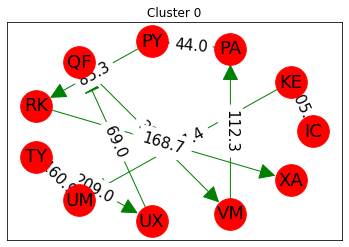

La solution pour le cluster 2 :


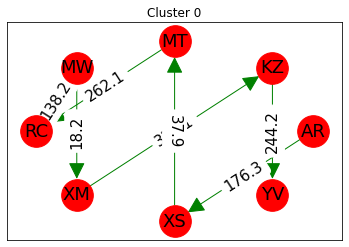

La solution pour le cluster 3 :


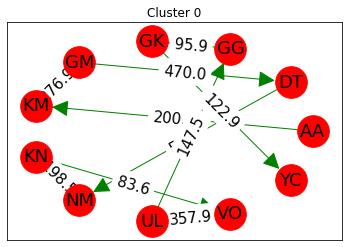

La solution pour le cluster 4 :


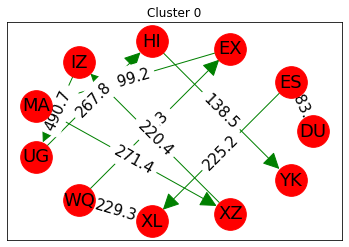

La solution pour le cluster 5 :


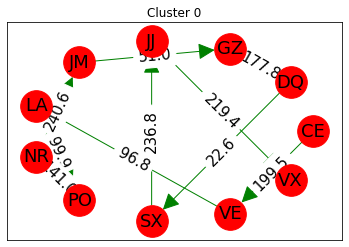

La solution pour le cluster 6 :


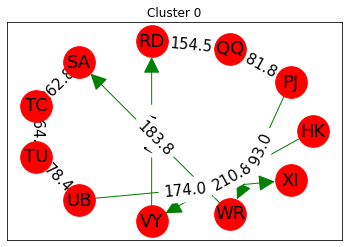

La solution pour le cluster 7 :


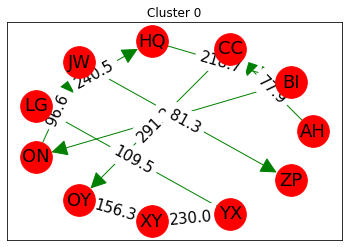

La solution pour le cluster 8 :


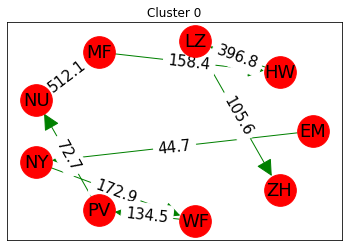

La solution pour le cluster 9 :


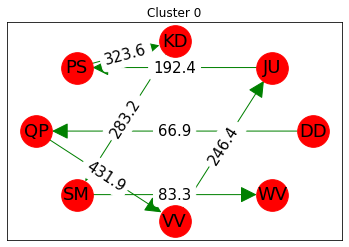

La solution pour le cluster 10 :


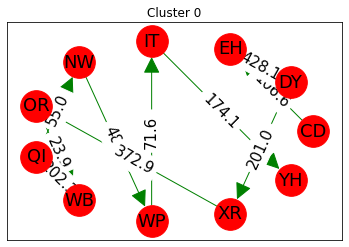

La solution pour le cluster 11 :


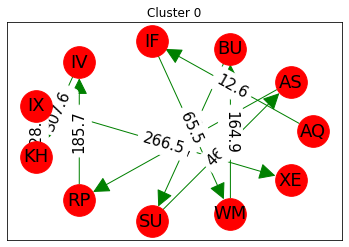

La solution pour le cluster 12 :


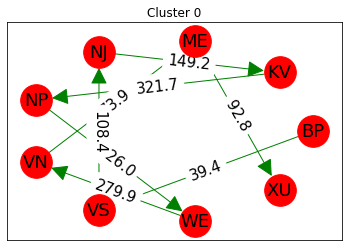

La solution pour le cluster 13 :


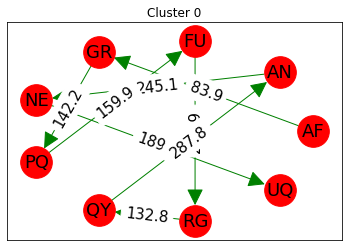

La solution pour le cluster 14 :


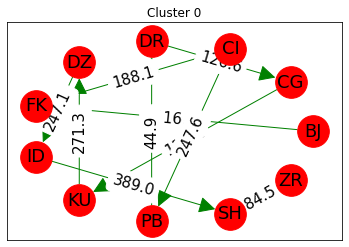

La solution pour le cluster 15 :


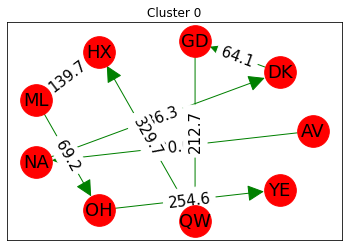

La solution pour le cluster 16 :


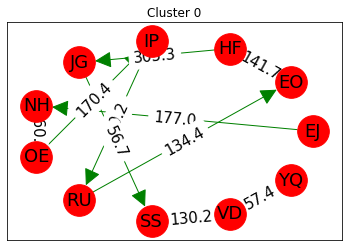

In [19]:
solution_draw_per_cluster(n_clusters=n_clusters)

In [20]:
departure_point_info=route_stops_data[route_stops_data["type"]=="Station"].to_dict(orient='index')[departure_point]

def get_distance(point,centroid):
    
    value=np.sqrt((centroid["lng"]-point['lng'])**2+(centroid["lat"]-point["lat"])**2)
    return value

def get_point_restricted_cluster(num_cluster,starts,ends):
    cluster=get_cluster_points(num_cluster=num_cluster)
    stop_stations=list(cluster.index)
    duree=[]
    for stop in stop_stations:
        date_start= datetime.strptime(starts[stop], '%Y-%m-%d %H:%M:%S')
        date_end= datetime.strptime(ends[stop], '%Y-%m-%d %H:%M:%S')
        time=date_end-date_start                          
        duree.append((stop,time))
        min_value=min(duree, key = lambda t: t[1])
    return min_value[0]

def get_farthest_point_departure(departure_point_info,closest_point_cluster,closest_point):
    L=[]
    indicies=route_stops_data.index
    points=route_stops_data.to_dict(orient="index")

    for i in range(len(points)):
        index=indicies[i]
        value=get_distance(points[index],departure_point_info)
        distance_closest_point=get_distance(points[closest_point[0]],points[index])
        if isNaN(value)!=True and points[index]["Cluster"]!=closest_point_cluster and value!=0:
            L.append((index,value))
    min_value=min(L, key = lambda t: t[1])
    return min_value

def get_closest_point_departure(departure_point_info):
    L=[]
    indicies=route_stops_data.index
    points=route_stops_data.to_dict(orient="index")

    for i in range(len(points)):
        index=indicies[i]
        value=get_distance(points[index],departure_point_info)
        if isNaN(value)!=True and value!=0:
            L.append((index,value))
    min_value=min(L, key = lambda t: t[1])
    return min_value
        

In [21]:
def apply_algorithm_order_clusters(n_clusters,flag=0,first=0):
    v_0=get_closest_point_departure(departure_point_info)
    closest_point_cluster=route_stops_data.loc[v_0[0]]["Cluster"]
    v_f=get_farthest_point_departure(departure_point_info,closest_point_cluster,v_0)
    farthest_point_cluster=route_stops_data.loc[v_f[0]]["Cluster"]
    stop_stations=[get_point_restricted_cluster(i,starts,ends) for i in range(n_clusters) if i!=closest_point_cluster and i!=farthest_point_cluster]
    stop_stations.insert(0,v_0[0])
    stop_stations.insert(-1,v_f[0])
    first_second=stop_stations[10]
    if first==0:
         stop_stations=stop_stations[:10]
    if first==1:
         stop_stations=stop_stations[10:n_clusters]
    path= r'C:\Program Files\IBM\ILOG\CPLEX_Studio2211\cplex\bin\x64_win64\cplex.exe'
    G=nx.DiGraph()
    nodes=stop_stations
    edges=[]
    for i in range(len(stop_stations)):
        for j in range(len(stop_stations)):
            if i!=j:
                index_row=stop_stations[i]
                index_column=stop_stations[j]
                value=route_distances.loc[index_row][index_column]
                edges.append((index_row,index_column,value))
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(edges)
    P=[]
    L=[]
    for i in stop_stations:
        for j in stop_stations:
            if i!=j:
                L.append(G[i][j]["weight"])
            else:
                L.append(0)
        P.append(L)
        L=[]
    a=[]
    b=[]
    for i in range(n_clusters):
        cluster_points=list(get_cluster_points(i).index)
        starts_cluster,ends_cluster=get_ab_per_cluster(cluster_points,starts,ends)
        if i!=closest_point_cluster and i!=farthest_point_cluster:
            a.append(max(starts_cluster))
            b.append(min(ends_cluster))
        if i==closest_point_cluster:
            a.insert(0,max(starts_cluster))
            b.insert(0,min(ends_cluster))
        if i==farthest_point_cluster:
            a.insert(-1,max(starts_cluster))
            b.insert(-1,min(ends_cluster))
            
    M=(max(b)+max(list(chain.from_iterable(P))))*10
    problem=pulp.LpProblem("Amazon_projet",pulp.LpMinimize)
    X=[[pulp.LpVariable(f"X{i}_{j}", cat=pulp.LpBinary) for j in range(len(nodes))] for i in range(len(nodes))]
    t=[pulp.LpVariable(name=f"t{i}",cat=pulp.LpContinuous,lowBound=a[i],upBound=b[i]) for i in range(len(nodes))]
    problem += pulp.lpSum([X[i][j]*P[i][j] for i in range(len(nodes))  for j in range(len(nodes))])
    for i in range(len(nodes)):
        if i != len(nodes)-1:
            problem += pulp.lpSum([X[i][j] for j in range(0, len(nodes))])==1
        if i!=len(nodes)-1 and i!=0:
            problem += pulp.lpSum([X[i][j] for j in range(0, len(nodes))]) ==pulp.lpSum([X[j][i] for j in range(0, len(nodes))])
        if i==0:
            problem += pulp.lpSum([X[i][j] for j in range(0, len(nodes))])-pulp.lpSum([X[j][i] for j in range(0, len(nodes))])==1
        if i==len(nodes)-1:
            problem += pulp.lpSum([X[i][j] for j in range(0, len(nodes))]) - pulp.lpSum([X[j][i] for j in range(0, len(nodes))]) == -1
        problem+=X[i][i]==0
    for j in range(len(nodes)):
        if j!=0:
            problem += pulp.lpSum([X[i][j] for i in range(0, len(nodes))]) == 1
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            t[i]+P[i][j]-t[j]<=M*(1-X[i][j])
    for k in range(len(nodes)):
        for S in range(2, len(nodes)):
            for subset in itertools.combinations([i for i in range(len(nodes)) if i != k], S):
                problem += pulp.lpSum([X[i][j] for i in subset for j in subset if i != j]) <= len(subset) - 1
    solver = pulp.CPLEX_CMD(path=path)
    problem.solve(solver)
    if flag==1:
        print("La valeur de la fonction objective: ",pulp.value(problem.objective))
        for i in range(len(nodes)):
             for j in range(len(nodes)):
                print(f"la valeur de X{nodes[i]}_{nodes[j]} est: {pulp.value(X[i][j])}")
    edges_selected=[]
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if first==0:
                if pulp.value(X[i][j])==1:
                    edges_selected.append((nodes[i],nodes[j],P[i][j]))
            if first==1:
                if pulp.value(X[i][j])==1:
                    edges_selected.append((nodes[i],nodes[j],P[i][j]))
                    
    if first==0:
        index_row=stop_stations[9]
        index_column=first_second
        value=route_distances.loc[index_row][index_column]
        edges_selected.append((stop_stations[9],first_second,value))
    
    return edges_selected

In [26]:
edges=apply_algorithm_order_clusters(n_clusters=n_clusters,flag=0,first=0) 
graph_path_1=[]
for edge in edges:
    node_1=route_stops_data.loc[edge[0]]["Cluster"]
    node_2=route_stops_data.loc[edge[1]]["Cluster"]
    graph_path_1.append((node_1,node_2,edge[2])) 

edges=apply_algorithm_order_clusters(n_clusters=n_clusters,flag=0,first=1) 
graph_path_2=[]
for edge in edges:
    node_1=route_stops_data.loc[edge[0]]["Cluster"]
    node_2=route_stops_data.loc[edge[1]]["Cluster"]
    graph_path_2.append((node_1,node_2,edge[2])) 


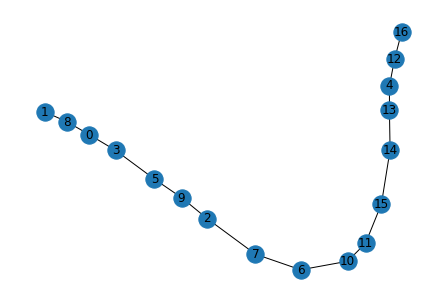

In [27]:
sol=nx.Graph()
nodes=[i for i in range(n_clusters)]
edges=graph_path_1+graph_path_2
sol.add_nodes_from(nodes)
sol.add_weighted_edges_from(edges)
nx.draw(sol,with_labels=True)
plt.savefig("cluster_path.png")

sol=nx.Graph()
sol.add_nodes_from(nodes)
sol.add_weighted_edges_from(edges)
nx.draw(sol)